# Introduction
Ce projet a pour but de réaliser un résumé en qq phrases de l'actualité sur quelques jours.
Le thémé choisi pour ce test est l'éléction présidentielle de 2022

# Scrapping
Premiere partie: le scrapping. Je vais scrapper ici les articles les plus récents de 3 grands journaux francais: Le Monde, Libéartion et Le Figaro.
Ces 3 sites comportent une section consacrée aux élections.

Malheureusement je ne possede pas de compte abonné pour ces trois sites, j'espere que seul les articles non-abonnés suffiront.

## Récupération des liens

## Le Monde
Premier journal de notre trio, je pensais pouvoir réutiliser le code de Quentin Gibon présent [ici](https://github.com/QuentinGib/WebNews_Summary/blob/main/LeMonde_Scrapping.ipynb), mais l'architecture du site de Le Monde a changé depuis.

In [ ]:
articles = {}
for typ in ["nbPrem", "nbOk"]:
  articles[typ] = {"LeM" : 0, "Lib" : 0, "Fig" : 0 }
articles["links"] = {"LeM" : [], "Lib" : [], "Fig" : [] }
articles

{'links': {'Fig': [], 'LeM': [], 'Lib': []},
 'nbOk': {'Fig': 0, 'LeM': 0, 'Lib': 0},
 'nbPrem': {'Fig': 0, 'LeM': 0, 'Lib': 0}}

In [ ]:
import requests
from bs4 import BeautifulSoup
from lxml import html

requete = requests.get("https://www.lemonde.fr/election-presidentielle-2022/")
page = requete.content
soupAccueil = BeautifulSoup(page)

In [ ]:
results = soupAccueil.find_all("div", {"class": "thread"})


In [ ]:
articles["nbPrem"]["LeM"], articles["nbOk"]["LeM"] = 0, 0
articles["links"]["LeM"] = []

nbLive = 0 #Seulement Le Monde réalise des Live

for r in results:
  if r.a.find("span", {"class": "icon__premium"}) is not None:
    articles["nbPrem"]["LeM"] += 1
    continue
  elif r.a.find("span", {"class": "sr-only"}) is not None:
    nbLive += 1
    continue
  else:
    articles["links"]["LeM"].append(r.a["href"])
    articles["nbOk"]["LeM"] += 1
nbLive, articles

## Libération

Pour ce journal l'utilisation de Selenium afin de simuler un navigateur est nécéssaire car les liens ne sont pas visibles sinon.

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=chrome_options)

In [ ]:
driver = webdriver.Chrome('chromedriver',options=chrome_options)
driver.maximize_window()
url = "https://www.liberation.fr/dossier/election-presidentielle-2022/"
driver.get(url)

In [ ]:
soupAccueil = BeautifulSoup(driver.page_source, "html5lib")

In [ ]:
results = soupAccueil.find_all("article", {"class": "flex border border_solid border_bottom border_color_grey_2 margin-lg-bottom padding-lg-bottom large-promo"})

In [ ]:
articles["nbPrem"]["Lib"], articles["nbOk"]["Lib"] = 0, 0
articles["links"]["Lib"] = []
for r in results:
  if r.find("span", {"class": "color_yellow_2 font_xs font_tertiary undefined"}) is not None:
    articles["nbPrem"]["Lib"] += 1
    continue
  else:
    articles["nbOk"]["Lib"] += 1
    articles["links"]["Lib"].append("https://www.liberation.fr" + r.a["href"])
articles

## Figaro
Je choisis de réutiliser Selenium afin de ne pas avoir de mauvaise surprises.


In [ ]:
url = "https://www.lefigaro.fr/elections/presidentielles"
driver.get(url)
soupAccueil = BeautifulSoup(driver.page_source, "html5lib")

In [ ]:
results = soupAccueil.find_all("article", {"class": ["fig-profile fig-container fig-profile--main fig-profile--fp fig-profile--article", "fig-profile fig-container fig-profile--main fig-profile--fp fig-profile--newsflash",
                                                     "fig-profile fig-container fig-profile--bottom fig-profile--fp fig-profile--article", "fig-profile fig-container fig-profile--bottom fig-profile--fp fig-profile--newsflash"]})

In [ ]:
articles["nbPrem"]["Fig"], articles["nbOk"]["Fig"] = 0, 0
articles["links"]["Fig"] = []

for r in results:
  articles["nbOk"]["Fig"] += 1
  articles["links"]["Fig"].append(r.a["href"])

articles

{'links': {'Fig': ['https://www.lefigaro.fr/politique/les-propos-de-macron-enflamment-la-campagne-20220105',
   'https://www.lefigaro.fr/elections/presidentielles/presidentielle-2022-emmanuel-macron-donne-largement-en-tete-loin-devant-pecresse-et-le-pen-20220105',
   'https://www.lefigaro.fr/elections/presidentielles/emmerder-faineants-bordel-le-langage-choc-de-macron-20220105',
   'https://www.lefigaro.fr/elections/presidentielles/indigne-siderant-vulgaire-la-sortie-d-emmanuel-macron-sur-les-non-vaccines-enflamme-la-classe-politique-20220105',
   'https://www.lefigaro.fr/elections/presidentielles/presidentielle-la-victoire-est-a-portee-de-main-assure-eric-zemmour-20220104',
   'https://www.lefigaro.fr/elections/presidentielles/covid-19-emmanuel-macron-a-tres-envie-d-emmerder-les-non-vaccines-20220104',
   'https://www.lefigaro.fr/flash-actu/presidentielle-macron-fait-du-covid-un-piege-pour-en-faire-le-sujet-de-la-presidentielle-selon-zemmour-20220104',
   'https://www.lefigaro.fr/elec

Le scrapping de Libération fut deja bien plus rapide que celui du Monde, mais celui du Figaro l'a été encore plus maintenat que j'ai pris le plis.

Nous voila avec 61 articles, majoritairement issus des deux plus grands journaux francais, Le Monde et Le Figaro (selon le nombre de lecteurs) respectivement centre gauche et droite, les 10 articles supplémentaires issus de Libération permettent de rééquilibrer un peu la balance.

Cet echantillion est eviddement trés peu représentatif, mais pour un premier jet, cela sera amplement suffisant.

## Récupération des articles

In [ ]:
import pandas as pd
df = pd.DataFrame(columns = ['links', 'content'])

# Le Monde

In [ ]:
for link in articles["links"]["LeM"]:
  requete = requests.get(link)
  page = requete.content
  soupAccueil = BeautifulSoup(page)
  results = soupAccueil.find_all("p", {"class": "article__paragraph "})
  content = ""
  for r in results:
    content +=  r.text + " "
  df = df.append({"links": link, "content": content}, ignore_index=True)


# Libération

In [ ]:
for link in articles["links"]["Lib"]:
  requete = requests.get(link)
  page = requete.content
  soupAccueil = BeautifulSoup(page)
  results = soupAccueil.find_all("p", {"class": "article_link"})
  content = ""
  for r in results:
    content +=  r.text + " "
  df = df.append({"links": link, "content": content}, ignore_index=True)


# Le Figaro

In [ ]:
for link in articles["links"]["Fig"]:
  requete = requests.get(link)
  page = requete.content
  soupAccueil = BeautifulSoup(page)
  results = soupAccueil.find_all("p", {"class": "fig-paragraph"})
  content = ""
  for r in results:
    content +=  r.text + " "
  df = df.append({"links": link, "content": content}, ignore_index=True)

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
df = pd.read_pickle("/content/gdrive/MyDrive/Colab_Files/Articles/df")

In [39]:
df.head(), len(df)

(                                               links                                            content
 0  https://www.lemonde.fr/election-presidentielle...  Jean-Luc Mélenchon, qui embarque pour sa trois...
 1  https://www.lemonde.fr/election-presidentielle...  Il était jusqu’ici resté discret, tant sur la ...
 2  https://www.lemonde.fr/election-presidentielle...  Un pas de plus dans l’accélération de la cours...
 3  https://www.lemonde.fr/politique/appel-temoign...  A moins de cent jours de l’élection présidenti...
 4  https://www.lemonde.fr/election-presidentielle...  Le Covid-19 n’a pas fini de perturber la campa...,
 60)

In [40]:
#Suppression de certains articles avec des bugs de scrappings.
df = df[~df['content'].str.contains("Ã")]

#Suppression de coquilles récurentes
df["content"] = df["content"].apply(lambda x: x.replace('\xa0', ' '))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Les articles ont tous été scrappé, nettoyé, et sont désormais dans un dataframe.

#Extractive Summarization

Dans cette partie, nous allons utiliser BERT, un model cree par Google en 2018.
BERT est un des modele de NLP les plus performants et possede surtout plusieurs variante en francais, dont CamemBERT, que nous allons utiliser aujourd'hui.


Je privilegie l'utilisation de moyenne par cluster pour ce projet. En effet il existe beaucoup de sujet différent traité lors du campagne présidentielle, et les articles publiés sur qq jours ratisse un trés grand nombre de sujet.
On cherche donc à retrouver les phrases représentant le mieux certains cluster.

La tokenisation sera faite via NLTK.punkt il creer une liste de phrase ou de bout de phrase que le model pourra analyser.
L'embedding va etre réaliser grace à BERT.


Ceci est fait avec le code suivant:

In [ ]:
!pip install transformers
!pip install bert-extractive-summarizer
!pip install sentencepiece
!pip install neuralcoref --no-binary neuralcoref
!python3 -m spacy download fr_core_news_md
!pip install omegaconf
!pip install hydra-core
!pip3 install spacy
!pip install bitarray
!pip install -U sentence-transformers

from sklearn.cluster import KMeans
from transformers import FlaubertModel, FlaubertTokenizer
import fr_core_news_sm
import fr_core_news_md
import numpy as np
import torch
import nltk
nltk.download("punkt")

In [ ]:
class Summarizer():

  def __init__(self):
    self.nlp = fr_core_news_md.load()
    self.stop_words = stopwords.words('french')

###### Load Model Methods ######

  def init_model(self, device=None, log=False):
    # Choosing device for language model
    if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.device = device

    model_name = 'camembert'
    self.model = torch.hub.load('pytorch/fairseq', 'camembert')
    self.model_name = model_name

    # Model Inference
    self.model.to(self.device)
    self.model.eval()

    # Log Info
    if log:
      self.init_log(self.model_name, self.device)

  def init_log(self, model_name, device):
    print(f'Summarizer: \'{model_name}\' successfully loaded on {device}.')

  def to(self, device):
    """
    Moves and/or casts the NLP model parameters and buffers.
    Parameters
    ----------
      device: string | device name.
    """

    self.device = device
    self.model.to(device)

###### "FIT" methods ######

  def fit(self, text, log=True):
    # Embed all the text
    try:
      if not isinstance(text, pd.core.series.Series):
        text = pd.Series(text)
    except:
      print('Data input error: text should be a numpy ndarray or a pandas '
            'series of str sentences')
      return
    
    self.text = text.to_numpy()
    self.text_embeddings = self.camembert_text_embedding(self.text)
    
  def camembert_embedding(self, sentence):
    """Return sentence CLS embedding computed with the camemBERT model"""
    # Get sentence tokens
    tokens = self.model.encode(sentence).to(self.device)

    # Pass to model
    with torch.no_grad():
      encoded_layers = self.model.extract_features(tokens,
                                                   return_all_hiddens=True)

    token_embeddings = torch.stack(encoded_layers, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    sum_vec = torch.sum(token_embeddings[-4:], dim=0)
    sentence_embedding = torch.mean(sum_vec,dim=0)
    return sentence_embedding.cpu().numpy()

  def camembert_text_embedding(self, text):
    """
    Return the camembert model embeddings associated with the text input.
    Parameters
    ----------
      text: numpy array of string | All text sentences      
    """
    embedded_sentences = list(map(self.camembert_embedding, text))

    return np.vstack(embedded_sentences)

###### "Cluster" methods ######
 def top_similarities(self, reference_embedding, embeddings, nb_top):
    """
    Return the nb_top embeddings indices closer to the reference_embedding.
    Parameter
    ---------
      reference_embedding: np.array | reference embedding for distance.
      embeddings: np.ndarray | embeddings to sort according to ref distance.
      nb_top: int | number of top indices to return.
    """

    # Compute similarity according to distance to reference.
    similarities = self.get_similarities(reference_embedding, embeddings)

    # Return nb_top indices
    top_indices = np.array(similarities).argsort()[::-1][:nb_top]
    return top_indices

  def cluster_embeddings(self, nb_clusters, nb_top):
    """
    Perform Kmeans clustering over the text embeddings.
    Return:
      dict{cluster_id, embeddings_indices}
      &
      dict{cluster_id, nb_top_embeddings_indices}
    
    Parameters
    ----------
      nb_clusters: int | number of clusters.
      nb_top: int | number of embbedings closer to cluster centroid to select. 
    """
    # Perform Kmeans
    Kmean_cluster = KMeans(n_clusters=nb_clusters).fit(self.text_embeddings)
    centroid = Kmean_cluster.cluster_centers_
    embeddings_cluster_labels = Kmean_cluster.labels_

    top_clustered_indices = {}

    # Go through each cluster
    for cluster_label in range(centroid.shape[0]):
      # Get all sentence indices
      indices = np.where(embeddings_cluster_labels == cluster_label)[0]

      # Get top sentences indices
      cluster_embeddings = self.text_embeddings[indices]
      top = self.top_similarities(centroid[cluster_label],
                                        cluster_embeddings, nb_top)
      top_clustered_indices[cluster_label] = indices[top].tolist()

    return embeddings_cluster_labels, top_clustered_indices  
  
  def clustering_summary(self, nb_clusters, nb_top, return_clusters=False):
    """
    Perform clustering summarization method.
    Return the summary.
    (optional) Return clustering results.
    Parameters
    ----------
      nb_clusters: int | number of clusters.
      nb_top: int | number of embbedings closer to cluster centroid to select.
      return_clusters: Bool | return clustering results if True.
    """
    # Kmeans clustering
    cluster_results = self.cluster_embeddings(nb_clusters, nb_top)

    # Get top sentence indices per cluster
    _, top_clustered_indices = cluster_results

    # Construct the summary
    summary_indices = []
    for indices in top_clustered_indices.values():
      summary_indices += indices
    summary = self.text[sorted(summary_indices)]

    if return_clusters:
      return summary, cluster_results

    return summary

In [ ]:
def load_preprocess_text(textArticle):
    text = " ".join(textArticle)
    tokenizer = nltk.data.load('tokenizers/punkt/PY3/french.pickle')
    phrases = tokenizer.tokenize(text)

    return np.array(phrases)
  
nb_sentences = 5

text = load_preprocess_text(allArticles)

summarizer = Summarizer()
summarizer.init_model(log=True)
summarizer.fit(text)

summary, cluster_results = summarizer.clustering_summary(nb_clusters=nb_sentences, nb_top=2, return_clusters=True)
for sentence in summary:
    print(sentence)

# Clustering : 5 phrases

1.   »  A rebours de la position de Jean-Luc Mélenchon, MmeTaubira estimait, elle, dans une tribune au Monde publiée le 29 décembre, que les « convergences » idéologiques à gauche « sont suffisantes pour nous 
permettre de gouverner ensemble cinq ans »
2.   J’appelle à un débat sans tabou que la crise sanitaire ne doit pas étouffer », a encore écrit la candidate de la droite avant de formuler ses vœux
3. Mais, évidemment, la majorité présidentielle s’imposera de respecter les jauges fixées dans tous ses événements », a écrit sur Twitter le président de l’Assemblée nationale et cadre de la majorité présidentielle, Richard Ferrand
4. La veille, dans sa vidéo où elle évoque sa possible candidature, l’ancienne ministre de la justice avait souligné l’importance de la « cohésion sociale partout, sans exclusive ni exclusion »
5. «Il est parfaitement normal que des candidats en campagne puissent se rendre auprès des forces armées et rendre publique leur visite pour tous les Français», a expliqué Reconquête, dans un communiqué

### Analyse
Il semble que nous ayons juste un top des citations les plus employées.
On réessaye en supprimant les citations du corpus.
Vraisemblablement il nous faut du coreRefence

In [41]:
import re
df["contentCit"] = df["content"].apply(lambda x: re.sub("\«.*\»", "", x))

In [ ]:
allArticles = df["contentCit"]

# Clustering sans citations: 6 phrases
1. Le 11 décembre, la candidate du parti Les Républicains (LR) fraîchement désignée par un vote en congrès, Valérie Pécresse avait dû restreindre son meeting d’investiture à la seule présence des cadres du parti, annulant le grand rassemblement de 5 000 personnes initialement prévu, porte de Versailles
2. Alors que le nombre de cas détectés ne cesse de croître, le candidat communiste Fabien Roussel ainsi que le candidat de LFI Jean-Luc Mélenchon ont aussi affirmé qu’ils distribueront des masques FFP2 gratuitement à l’entrée de leurs meetings
3. Avec une ligne politique qu'il a tracée depuis son adresse aux Français le 12 juillet dernier : mettre coûte que coûte la pression sur les quelque cinq millions de Français non-vaccinés
4. Invité ce lundi sur France Inter, le chef de file de la France Insoumise a redit son opposition à l'instauration d'une telle mesure pour ses rassemblements, précisant en revanche que des masques FFP2 seraient distribués aux participants lors de ses meetings
5. Au lendemain de la dégradation du domicile de l'ancienne finaliste de la primaire écologiste Sandrine Rousseau par, selon elle, des , avait écrit Éric Zemmour via un communiqué
6. En vue de l'élection présidentielle, le parti présidentiel affûte ses armes

### Analyse
Le resultat semble cohérent pour les 4 premieres, la cinquieme par contre n'est pas compréhensible car les citations manquent et la sixieme ne porte pas les éléments clefs.

De plus, le clustering semble ne pas trés bien marcher. Chaque cluster doit donner deux phrases, mais on peine a trouver deux phrases en accord

Ces résultats sont trés peu exploitables.

# Coreference 

Nos résultats manquants de sens, je pense que rajouter de la coreference pourrait rendre le résumé plus probant.
Cela permet de rendre du contexte aux pronoms notameent.

Comme ecris ci dessous, mon implémentation de coreference fais planter collab. Je n'ai donc pas réussi a implémenter cette méthode au code précédent, c'est donc pour cela que nous utiliserons "**bert-extractive-summarize**" qui est allie clustering et coreference.

In [ ]:
from summarizer import Summarizer
from summarizer.text_processors.coreference_handler import CoreferenceHandler

handler = CoreferenceHandler(greedyness=.4)

model = Summarizer(sentence_handler=handler)#, custom_model=camembert, custom_tokenizer=tokenizer)
result = model(allArticles, num_sentences=5)

# Fais redemarrer le kernel de colab...

In [ ]:
from summarizer import Summarizer
from transformers import *

# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
custom_config = AutoConfig.from_pretrained('camembert-base')
custom_config.output_hidden_states=True
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
camembert = CamembertModel.from_pretrained("camembert-base", config=custom_config)
model = Summarizer(custom_model=camembert, custom_tokenizer=tokenizer)
result = model(allArticles, num_sentences=6)
print("".join(result))



## bert-extractive-summarize - Sans citation
1. Jean-Luc Mélenchon, qui embarque pour sa troisième élection présidentielle, n’en est pas non plus à son coup d’essai en termes de déploiement d’innovations technologiques. 
2. A moins de cent jours de l’élection présidentielle, le candidat de la France insoumise a une nouvelle fois rejeté, lundi 3 janvier sur France Inter, l’appel lancé par Anne Hidalgo et Christiane Taubira à participer à un scrutin pour éviter les multiples postulants à gauche. 
3. Avec une ligne politique qu'il a tracée depuis son adresse aux Français le 12 juillet dernier : mettre coûte que coûte la pression sur les quelque cinq millions de Français non-vaccinés. 
4. : C'est au plus tard le quatrième vendredi avant le scrutin, soit le 11 mars 2022, que le gouvernement doit publier la liste officielle des candidats, après validation par le Conseil constitutionnel. 
5. Entre le 11 et le 28 mars, c'est ensuite la règle de l'équité dans la présence médiatique s'applique entre les candidats. 
6. Sa présence sous l'édifice, sans le drapeau français, a suscité les réactions indignées de trois candidats à l'élection présidentielle : Marine Le Pen, Éric Zemmour et Valérie Pécresse. ,

## Analyse

Sans citation, le résumé est bien plus lisible que celui que nous avions précedement.

Je pense que ce résultat est du à la partie de Corereference.
En effet, les deux premieres phrases parlent de la gauche/france insoumise et sont bien mis en relation alors qu'il n'y a pas de mots en communs entre les deux.
Pour la sixieme il ne manque le mot "drapeau européen" pour faire sens, integrer coreference eux réponses est surement une bonne idée.

## bert-extractive-summarize - Avec citation
1. Jean-Luc Mélenchon, qui embarque pour sa troisième élection présidentielle, n’en est pas non plus à son coup d’essai en termes de déploiement d’innovations technologiques. 
2. Comme chaque année, le président de la République donnera les siens à 20 heures, mais ses opposants ont préféré prendre les devants : plusieurs candidats à l’élection présidentielle ont devancé Emmanuel Macron – qui n’est toujours pas officiellement candidat – en présentant, dès la fin de la matinée, vendredi 31 décembre, leurs vœux pour 2022. 
3. « Il y a en coulisse une manière de fonctionner de toute une mouvance qui accompagne certains candidats, et en l’occurrence Eric Zemmour, qui vise à intimider quiconque a une parole opposée à eux », s’inquiète le député « insoumis », qui demande au polémiste de « condamner la vidéo » et aux pouvoirs publics « d’envoyer un signal clair » à un peu moins de quatre mois de la présidentielle. 
4. Arnaud Montebourg, ancien ministre du redressement productif (2012-2014) et candidat à l’élection présidentielle de 2022, qui a appelé à l’union de la gauche derrière un candidat unique mercredi dernier, et a depuis tenté de démarcher chacun des prétendants, a accueilli la nouvelle avec entrain dans un tweet : « Christiane Taubira propose de nous unir (…). 
5. Le centriste agite le chiffon rouge lorsqu’il affirme que «l’année 1981 sera encore une année difficile» : «Nous ne pouvons pas compter en 1981 sur des facilités venues de l’extérieur. 
6. On ne va pas se battre sur le taux de TVA, ou je ne sais quelle virgule de telle loi...», a-t-il exhorté, réclamant une «union sacrée» de tous les candidats qui s'opposent aux restrictions sanitaires.



## Analyse
Avec citation, on retrouve encore une fois qq chose d'assez chargé, et sans beaucoup de sens.
Typiquement les deux dernieres manque de contexte.







# Conclusion

Je trouve ce test assez prometteur. Voici quelques pistes que je compte explorer afin de réaliser un condensé de news cohérent.

Les elections est un sujet assez particulier avec toutes ces citations. Je pense que le meilleur moyen de gérer cela est de laisser les citations au model, et de ne garder que les phrases sans citations par cluster.

Appliquer la coreference sur les phrase trouver afin de leur rendre leur contexte aiderait aussi grandement à la compréhension.


De plus, un plus grand corpus permettra surmement de mieux représenter tout le corps politique car pour l'instant, la gauche et la présidence sont les plus représentés, autant dans nos résumés que dans les nuages de mots suivant:

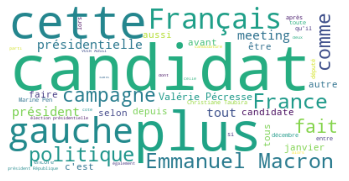

In [91]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download("stopwords")

wordcloud = WordCloud(background_color = 'white', stopwords = stop_words, max_words = 50).generate(allArticles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

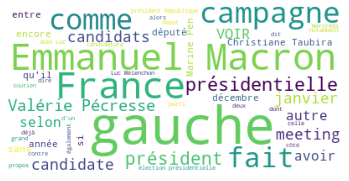

In [94]:
stop_words_ex = ["politique", "Français", "candidat", "cette","plus", "être", "tout", "tous", "toutes", "c'est", "faire", "avant", "aussi", "après", "lors", "depuis"]
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words + stop_words_ex, max_words = 50).generate(allArticles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

On remarque, surtout sur le deuxieme nuage ou plus de mots sont éliminés, qu'Emannuel Macron est sur-représenté. Son absence des résumés est surement dûe au fait que chaque phrase parlant du gouvernement, etait située proche des mots "Emannuel Macron".

# Références

- https://piaf.etalab.studio/francophonie-ia-english/
- https://lesdieuxducode.com/blog/2019/4/bert--le-transformer-model-qui-sentraine-et-qui-represente
- https://github.com/dmmiller612/bert-extractive-summarizer
- https://hal.archives-ouvertes.fr/hal-02784755/file/151.pdf
- https://github.com/QuentinGib/WebNews_Summary/blob/main/LeMonde_Scrapping.ipynb
- https://github.com/ialifinaritra/Text_Summarization/blob/main/Summarizer.py
- https://datascientest.com/wordcloud-python
- https://huggingface.co/camembert-base